In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import tensorflow as tf
from io import BytesIO

graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)

In [2]:
model_fn = '../data/tensorflow_inception_graph.pb'

with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

In [3]:
t_input = tf.placeholder(np.float32, name='input')

imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input - imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input': t_preprocessed})

In [4]:
layers = [op.name for op in graph.get_operations()
          if op.type == 'Conv2d' and 'import/' in op.name]

feature_nums = [int(graph.get_tensor_by_name(name + ':0').get_shape()[-1])
                for name in layers]

In [5]:
layer = 'mixed4d_3x3_bottleneck_pre_relu'
channel = 30
img_noise = np.random.uniform(size=(224, 224, 3)) + 100.0

In [6]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1) * 255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    plt.imshow(a)
    plt.show()

In [7]:
def T(layer):
    return graph.get_tensor_by_name("import/%s:0" % layer)

In [8]:
def tffunc(*argtypes):
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)),
                            session=kw.get('session'))
        return wrapper
    return wrap

In [9]:
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0, :, :, :]

In [10]:
def calc_grad_tiled(img, t_grad, tile_size=512):
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h - sz // 2, sz), sz):
        for x in range(0, max(w - sz // 2, sz), sz):
            sub = img_shift[y: y + sz, x: x + sz]
            g = sess.run(t_grad, {t_input: sub})
            grad[y:y + sz, x:x + sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

In [11]:
def render_deepdream(t_obj, img0=img_noise, iter_n=10,
                     step=1.5, octave_n=4, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj)
    t_grad = tf.gradients(t_score, t_input)[0]
    img = img0
    octaves = []
    for i in range(octave_n - 1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw) / octave_scale))
        hi = img - resize(lo, hw)
        img = lo
        octaves.append(hi)
        
    for octave in range(octave_n):
        if octave > 0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2]) + hi
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g * (step / (np.abs(g).mean() + 1e-7))
            print('.', end = '')
        showarray(img / 255.0)

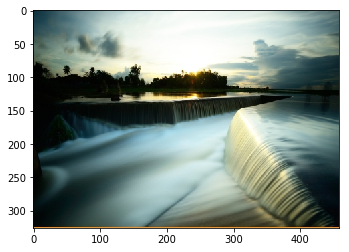

...............

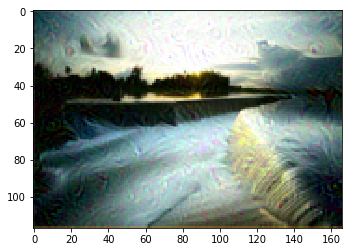

...............

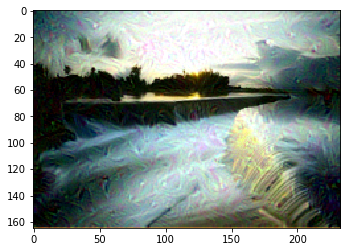

...............

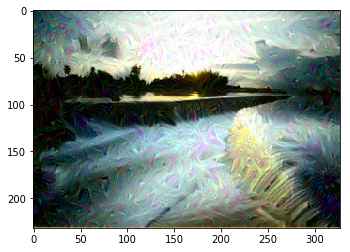

...............

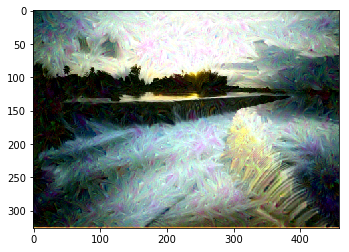

In [12]:
resize = tffunc(np.float32, np.int32)(resize)
img0 = PIL.Image.open('../data/book_cover.jpg')
img0 = np.float32(img0)
showarray(img0 / 255)
render_deepdream(T(layer)[:, :, :, channel], img0, iter_n=15)
sess.close()